# Setup

In [6]:
%pip install torch
%pip install transformer_lens
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install datasets
%pip install tiktoken
%pip install numpy
%pip install tqdm
%pip install circuitsvis

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import datasets
from datasets import load_dataset
import tiktoken
import os
from tqdm.notebook import tqdm
import math
import time
from transformers import GPT2Tokenizer
from transformer_lens import HookedTransformer, HookedTransformerConfig
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import circuitsvis as cv
from IPython.display import display

# Model Imports

In [9]:
from model.gpt_neo import GPTNeo
from model.config import GPTNeoConfig

# Loading Pretrained model

In [10]:
config = GPTNeoConfig(hidden_size=128)
model = GPTNeo(config)
model.load_state_dict(torch.load('best_model_128width_120000batches.pt', map_location=torch.device('cpu')))
model.eval()

GPTNeo(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 128)
    (wpe): Embedding(2048, 128)
    (h): ModuleList(
      (0-7): 8 x GPTNeoBlock(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (attention): ModuleDict(
            (k_proj): Linear(in_features=128, out_features=128, bias=False)
            (v_proj): Linear(in_features=128, out_features=128, bias=False)
            (q_proj): Linear(in_features=128, out_features=128, bias=False)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (c_proj): Linear(in_features=512, out_features=128, bias=True)
          (act): NewGELUActivation()
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_

# Interpretability Experiment 1

### Model Structure:

```plaintext
GPTNeo(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 128)
    (wpe): Embedding(2048, 128)
    (h): ModuleList(
      (0-7): 8 x GPTNeoBlock(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (attention): ModuleDict(
            (k_proj): Linear(in_features=128, out_features=128, bias=False)
            (v_proj): Linear(in_features=128, out_features=128, bias=False)
            (q_proj): Linear(in_features=128, out_features=128, bias=False)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (c_proj): Linear(in_features=512, out_features=128, bias=True)
          (act): NewGELUActivation()
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    ...
  )
)


## Wrapper

In [36]:
class PreTrainedGPTNeoWrapper(HookedTransformer):
    def __init__(self, gpt_neo_model, is_ablated=True):
        cfg = self.extract_config(gpt_neo_model.config)
        
        # Might be a good idea to add to config
        self.is_ablated = is_ablated
        
        hooked_cfg = HookedTransformerConfig(
            n_layers=cfg["n_layers"],
            d_model=cfg["d_model"],
            d_head=cfg["d_head"],
            n_heads=cfg["n_heads"],
            d_mlp=cfg["d_mlp"],
            d_vocab=cfg["d_vocab"],
            n_ctx=cfg["n_ctx"],
            act_fn="gelu",
            tokenizer_name="gpt2",
        )
        
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        
        super().__init__(cfg=hooked_cfg, tokenizer=tokenizer, move_to_device=False)
        
        self.gpt_neo = gpt_neo_model
        self.setup_hooks()

    @staticmethod
    def extract_config(config):
        return {
            "d_model": config.hidden_size,
            "d_head": config.hidden_size // config.num_heads,
            "n_heads": config.num_heads,
            "d_mlp": config.mlp_hidden_size,
            "n_layers": config.num_layers,
            "n_ctx": config.max_position_embeddings,
            "d_vocab": config.vocab_size,
        }

    def setup_hooks(self):
        self.hook_dict = {}
        for i in range(self.cfg.n_layers):
            self.hook_dict[f"blocks.{i}.attn"] = self.gpt_neo.transformer.h[i].attn
            self.hook_dict[f"blocks.{i}.mlp"] = self.gpt_neo.transformer.h[i].mlp
            
        if self.is_ablated:
            
            # Add ablation hooks
            self.hook_dict[f"attention ablations"] = self.gpt_neo.attention_ablations_head
            self.hook_dict[f"mlp ablations"] = self.gpt_neo.neuron_ablations_head

    def forward(self, input_ids):
        return self.gpt_neo(input_ids)

    def run_with_hooks(
        self, 
        input_ids, 
        fwd_hooks: List[tuple] = [], 
        return_type: str = "logits",
    ) -> Dict[str, Any]:
        hook_output = {}
        
        def create_hook(layer_name):
            def hook(module, input, output):
                print(f"Hook triggered for {layer_name}")
                if isinstance(output, tuple):
                    attn_output = output[-1].detach()
                else:
                    attn_output = output.detach()
                print(f"Hook captured output with shape: {attn_output.shape}")
                hook_output[layer_name] = attn_output
            return hook

        hooks = []
        for name, module in self.hook_dict.items():
            print(f"Registering hook on {name}")
            hooks.append(module.register_forward_hook(create_hook(name)))

        try:
            print("Running model with hooks...")
            output = self.forward(input_ids)
            print("Model run completed.")

            if isinstance(output, dict):
                if return_type == "logits":
                    return output.get("logits", None)
                elif return_type == "loss":
                    logits = output.get("logits", None)
                    if logits is not None:
                        return self.compute_loss(logits, input_ids)
                    else:
                        raise ValueError("No logits found in the model output.")
                elif return_type == "both":
                    logits = output.get("logits", None)
                    if logits is not None:
                        return logits, self.compute_loss(logits, input_ids)
                    else:
                        raise ValueError("No logits found in the model output.")
                elif return_type == "hook_data":
                    return hook_output
                else:
                    raise ValueError(f"Invalid return_type: {return_type}")
            else:
                if return_type == "logits":
                    return output
                elif return_type == "loss":
                    return self.compute_loss(output, input_ids)
                elif return_type == "both":
                    return output, self.compute_loss(output, input_ids)
                elif return_type == "hook_data":
                    return hook_output
                else:
                    raise ValueError(f"Invalid return_type: {return_type}")

        finally:
            for hook in hooks:
                hook.remove()

    def run_with_cache(
        self, 
        input_ids, 
        return_type: str = "logits",
    ) -> Dict[str, Any]:
        cache = {}
        
        def create_cache_hook(layer_name):
            def hook(module, input, output):
                if isinstance(output, tuple):
                    cache[layer_name] = output[-1].detach()
                else:
                    cache[layer_name] = output.detach()
            return hook

        hooks = []
        for name, module in self.hook_dict.items():
            hooks.append(module.register_forward_hook(create_cache_hook(name)))

        try:
            output = self.forward(input_ids)

            if isinstance(output, dict):
                logits = output.get("logits", None)
            else:
                logits = output

            if return_type == "logits":
                return logits, cache
            elif return_type == "loss":
                if logits is not None:
                    loss = self.compute_loss(logits, input_ids)
                    return loss, cache
                else:
                    raise ValueError("No logits found in the model output.")
            elif return_type == "both":
                if logits is not None:
                    loss = self.compute_loss(logits, input_ids)
                    return logits, loss, cache
                else:
                    raise ValueError("No logits found in the model output.")
            else:
                raise ValueError(f"Invalid return_type: {return_type}")

        finally:
            for hook in hooks:
                hook.remove()

    def compute_loss(self, logits, targets):
        return torch.nn.functional.cross_entropy(
            logits.view(-1, logits.size(-1)), 
            targets.view(-1), 
            ignore_index=-100
        )


## Visualizations

In [12]:
def get_attention_patterns(model, input_ids):
    attention_patterns = []
    
    def attention_hook(module, input, output):
        # The output is the attended information
        attention_patterns.append(output.detach())

    hooks = [layer.attn.register_forward_hook(attention_hook) for layer in model.transformer.h]
    
    with torch.no_grad():
        model(input_ids)
    
    for hook in hooks:
        hook.remove()
    
    return torch.stack(attention_patterns)

def visualize_attention(attention_patterns, tokens):
    num_layers, batch_size, seq_len, hidden_size = attention_patterns.shape
    
    fig, axes = plt.subplots(4, 2, figsize=(20, 30))
    fig.suptitle('Attention Output Magnitudes Across Layers')
    
    for layer in range(num_layers):
        ax = axes[layer // 2, layer % 2]
        
        # Calculate the magnitude of attention outputs
        attn_magnitude = attention_patterns[layer, 0].norm(dim=-1).cpu().numpy()
        
        sns.heatmap(attn_magnitude.reshape(1, -1), ax=ax, cmap='viridis', xticklabels=tokens, yticklabels=['Magnitude'])
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('Token Position')
    
    plt.tight_layout()
    plt.show()


def get_attention_info(model, input_ids):
    layer_inputs = []
    layer_outputs = []
    
    def attention_hook(module, input, output):
        layer_inputs.append(input[0].detach())
        if isinstance(output, tuple):
            layer_outputs.append(output[0].detach())  # Assuming the first element is the main output
        else:
            layer_outputs.append(output.detach())

    hooks = [layer.attn.register_forward_hook(attention_hook) for layer in model.transformer.h]
    
    with torch.no_grad():
        model(input_ids)
    
    for hook in hooks:
        hook.remove()
    
    print("Number of captured outputs:", len(layer_outputs))
    print("Input shape for first layer:", layer_inputs[0].shape)
    print("Output shape for first layer:", layer_outputs[0].shape)
    
    # Combine every 3 outputs into a single layer output
    attention_inputs = layer_inputs[::3]  # Take every 3rd input
    attention_outputs = [torch.stack(layer_outputs[i:i+3]).sum(0) for i in range(0, len(layer_outputs), 3)]
    
    print("Number of processed layers:", len(attention_outputs))
    
    return attention_inputs, attention_outputs



def analyze_attention(attention_inputs, attention_outputs, tokens):
    num_layers = len(attention_outputs)
    assert num_layers == 8, f"Expected 8 layers, got {num_layers}"
    
    fig, axes = plt.subplots(4, 2, figsize=(20, 40))
    fig.suptitle('Attention Analysis Across Layers')
    
    for layer in range(num_layers):
        ax = axes[layer // 2, layer % 2]
        
        # Compute the change in representation
        input_norm = attention_inputs[layer].norm(dim=-1)
        output_norm = attention_outputs[layer].norm(dim=-1)
        
        change = (output_norm - input_norm).cpu().numpy()
        
        sns.heatmap(change, ax=ax, cmap='coolwarm', center=0, 
                    xticklabels=tokens, yticklabels=tokens)
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('Token Position')
        ax.set_ylabel('Token Position')
        
        # Rotate x-axis labels for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()




def analyze_mlp_activations(hook_data):
    
    # We should probably not use global variables.
    # Might be better if these functions are part of a class.
    for layer in range(wrapped_model.cfg.n_layers):
        mlp_activations = hook_data[f"blocks.{layer}.mlp"]
        print(f"Layer {layer} MLP Activations Shape:", mlp_activations.shape)
        
        activations = mlp_activations.detach().cpu().numpy()
        print(f"Layer {layer} MLP Activation Stats:")
        print(f"  Mean: {activations.mean():.4f}")
        print(f"  Std Dev: {activations.std():.4f}")
        print(f"  Min: {activations.min():.4f}")
        print(f"  Max: {activations.max():.4f}")
        
        plt.figure(figsize=(10, 6))
        plt.hist(activations.flatten(), bins=50)
        plt.title(f'Distribution of MLP Activations - Layer {layer}')
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.show()

def analyze_ablations(model):
    attention_ablations = model.attention_ablations_head.weight.detach().cpu().numpy()
    neuron_ablations = model.neuron_ablations_head.weight.detach().cpu().numpy()
    
    print("Attention Ablations Shape:", attention_ablations.shape)
    print("Neuron Ablations Shape:", neuron_ablations.shape)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(attention_ablations, cmap='viridis', aspect='auto')
    plt.title('Attention Ablations')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(neuron_ablations, cmap='viridis', aspect='auto')
    plt.title('Neuron Ablations')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

In [34]:
# Load the pre-trained model
config = GPTNeoConfig(hidden_size=128)
model = GPTNeo(config)
model.load_state_dict(torch.load('best_model_128width_120000batches.pt', map_location=torch.device('cpu')))
model.eval()

GPTNeo(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 128)
    (wpe): Embedding(2048, 128)
    (h): ModuleList(
      (0-7): 8 x GPTNeoBlock(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (attention): ModuleDict(
            (k_proj): Linear(in_features=128, out_features=128, bias=False)
            (v_proj): Linear(in_features=128, out_features=128, bias=False)
            (q_proj): Linear(in_features=128, out_features=128, bias=False)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (c_proj): Linear(in_features=512, out_features=128, bias=True)
          (act): NewGELUActivation()
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_

In [37]:
# Initialize the wrapper with the pre-trained model
wrapped_model = PreTrainedGPTNeoWrapper(model)

In [38]:
# Sanity Testing
input_text = "Once upon a time, in a land far away, there lived a brave little mouse."
input_ids = wrapped_model.tokenizer(input_text, return_tensors="pt").input_ids
tokens = wrapped_model.tokenizer.convert_ids_to_tokens(input_ids[0])
print(f"Number of tokens: {len(tokens)}")
print(f"Tokens: {tokens}")

Number of tokens: 18
Tokens: ['Once', 'Ġupon', 'Ġa', 'Ġtime', ',', 'Ġin', 'Ġa', 'Ġland', 'Ġfar', 'Ġaway', ',', 'Ġthere', 'Ġlived', 'Ġa', 'Ġbrave', 'Ġlittle', 'Ġmouse', '.']


In [39]:
# Run with hooks and get various outputs
logits = wrapped_model.run_with_hooks(input_ids, return_type="logits")
loss = wrapped_model.run_with_hooks(input_ids, return_type="loss")
hook_data = wrapped_model.run_with_hooks(input_ids, return_type="hook_data")

# Run with cache
logits, cache = wrapped_model.run_with_cache(input_ids, return_type="logits")

Registering hook on blocks.0.attn
Registering hook on blocks.0.mlp
Registering hook on blocks.1.attn
Registering hook on blocks.1.mlp
Registering hook on blocks.2.attn
Registering hook on blocks.2.mlp
Registering hook on blocks.3.attn
Registering hook on blocks.3.mlp
Registering hook on blocks.4.attn
Registering hook on blocks.4.mlp
Registering hook on blocks.5.attn
Registering hook on blocks.5.mlp
Registering hook on blocks.6.attn
Registering hook on blocks.6.mlp
Registering hook on blocks.7.attn
Registering hook on blocks.7.mlp
Registering hook on attention ablations
Registering hook on mlp ablations
Running model with hooks...
Hook triggered for blocks.0.attn
Hook captured output with shape: torch.Size([1, 18, 128])
Hook triggered for blocks.0.mlp
Hook captured output with shape: torch.Size([1, 18, 128])
Hook triggered for blocks.1.attn
Hook captured output with shape: torch.Size([1, 18, 128])
Hook triggered for blocks.1.mlp
Hook captured output with shape: torch.Size([1, 18, 128])


places where ablation_mask is nonzero: [[0, 0, 76], [0, 0, 79], [0, 1, 76], [0, 2, 76], [0, 2, 127], [0, 3, 76], [0, 3, 84], [0, 3, 117], [0, 4, 76], [0, 5, 65], [0, 5, 76], [0, 6, 76], [0, 7, 65], [0, 7, 76], [0, 7, 84], [0, 8, 65], [0, 8, 76], [0, 9, 65], [0, 9, 76], [0, 10, 65], [0, 10, 76], [0, 11, 76], [0, 11, 84], [0, 12, 76], [0, 12, 84], [0, 12, 117], [0, 13, 76], [0, 13, 84], [0, 13, 115], [0, 14, 74], [0, 14, 76], [0, 14, 84], [0, 14, 115], [0, 15, 76], [0, 15, 115], [0, 16, 76], [0, 16, 115], [0, 16, 127], [0, 17, 4], [0, 17, 15], [0, 17, 65], [0, 17, 74], [0, 17, 76], [0, 17, 86], [0, 17, 92], [0, 17, 97], [0, 17, 127]]
places where ablation_mask is nonzero: [[0, 2, 104], [0, 17, 106]]
places where ablation_mask is nonzero: []
places where ablation_mask is nonzero: [[0, 2, 71], [0, 3, 71], [0, 6, 71], [0, 13, 71], [0, 14, 71], [0, 15, 71], [0, 16, 71], [0, 17, 71]]
places where ablation_mask is nonzero: [[0, 8, 19], [0, 13, 19], [0, 14, 19], [0, 15, 19]]
places where ablati

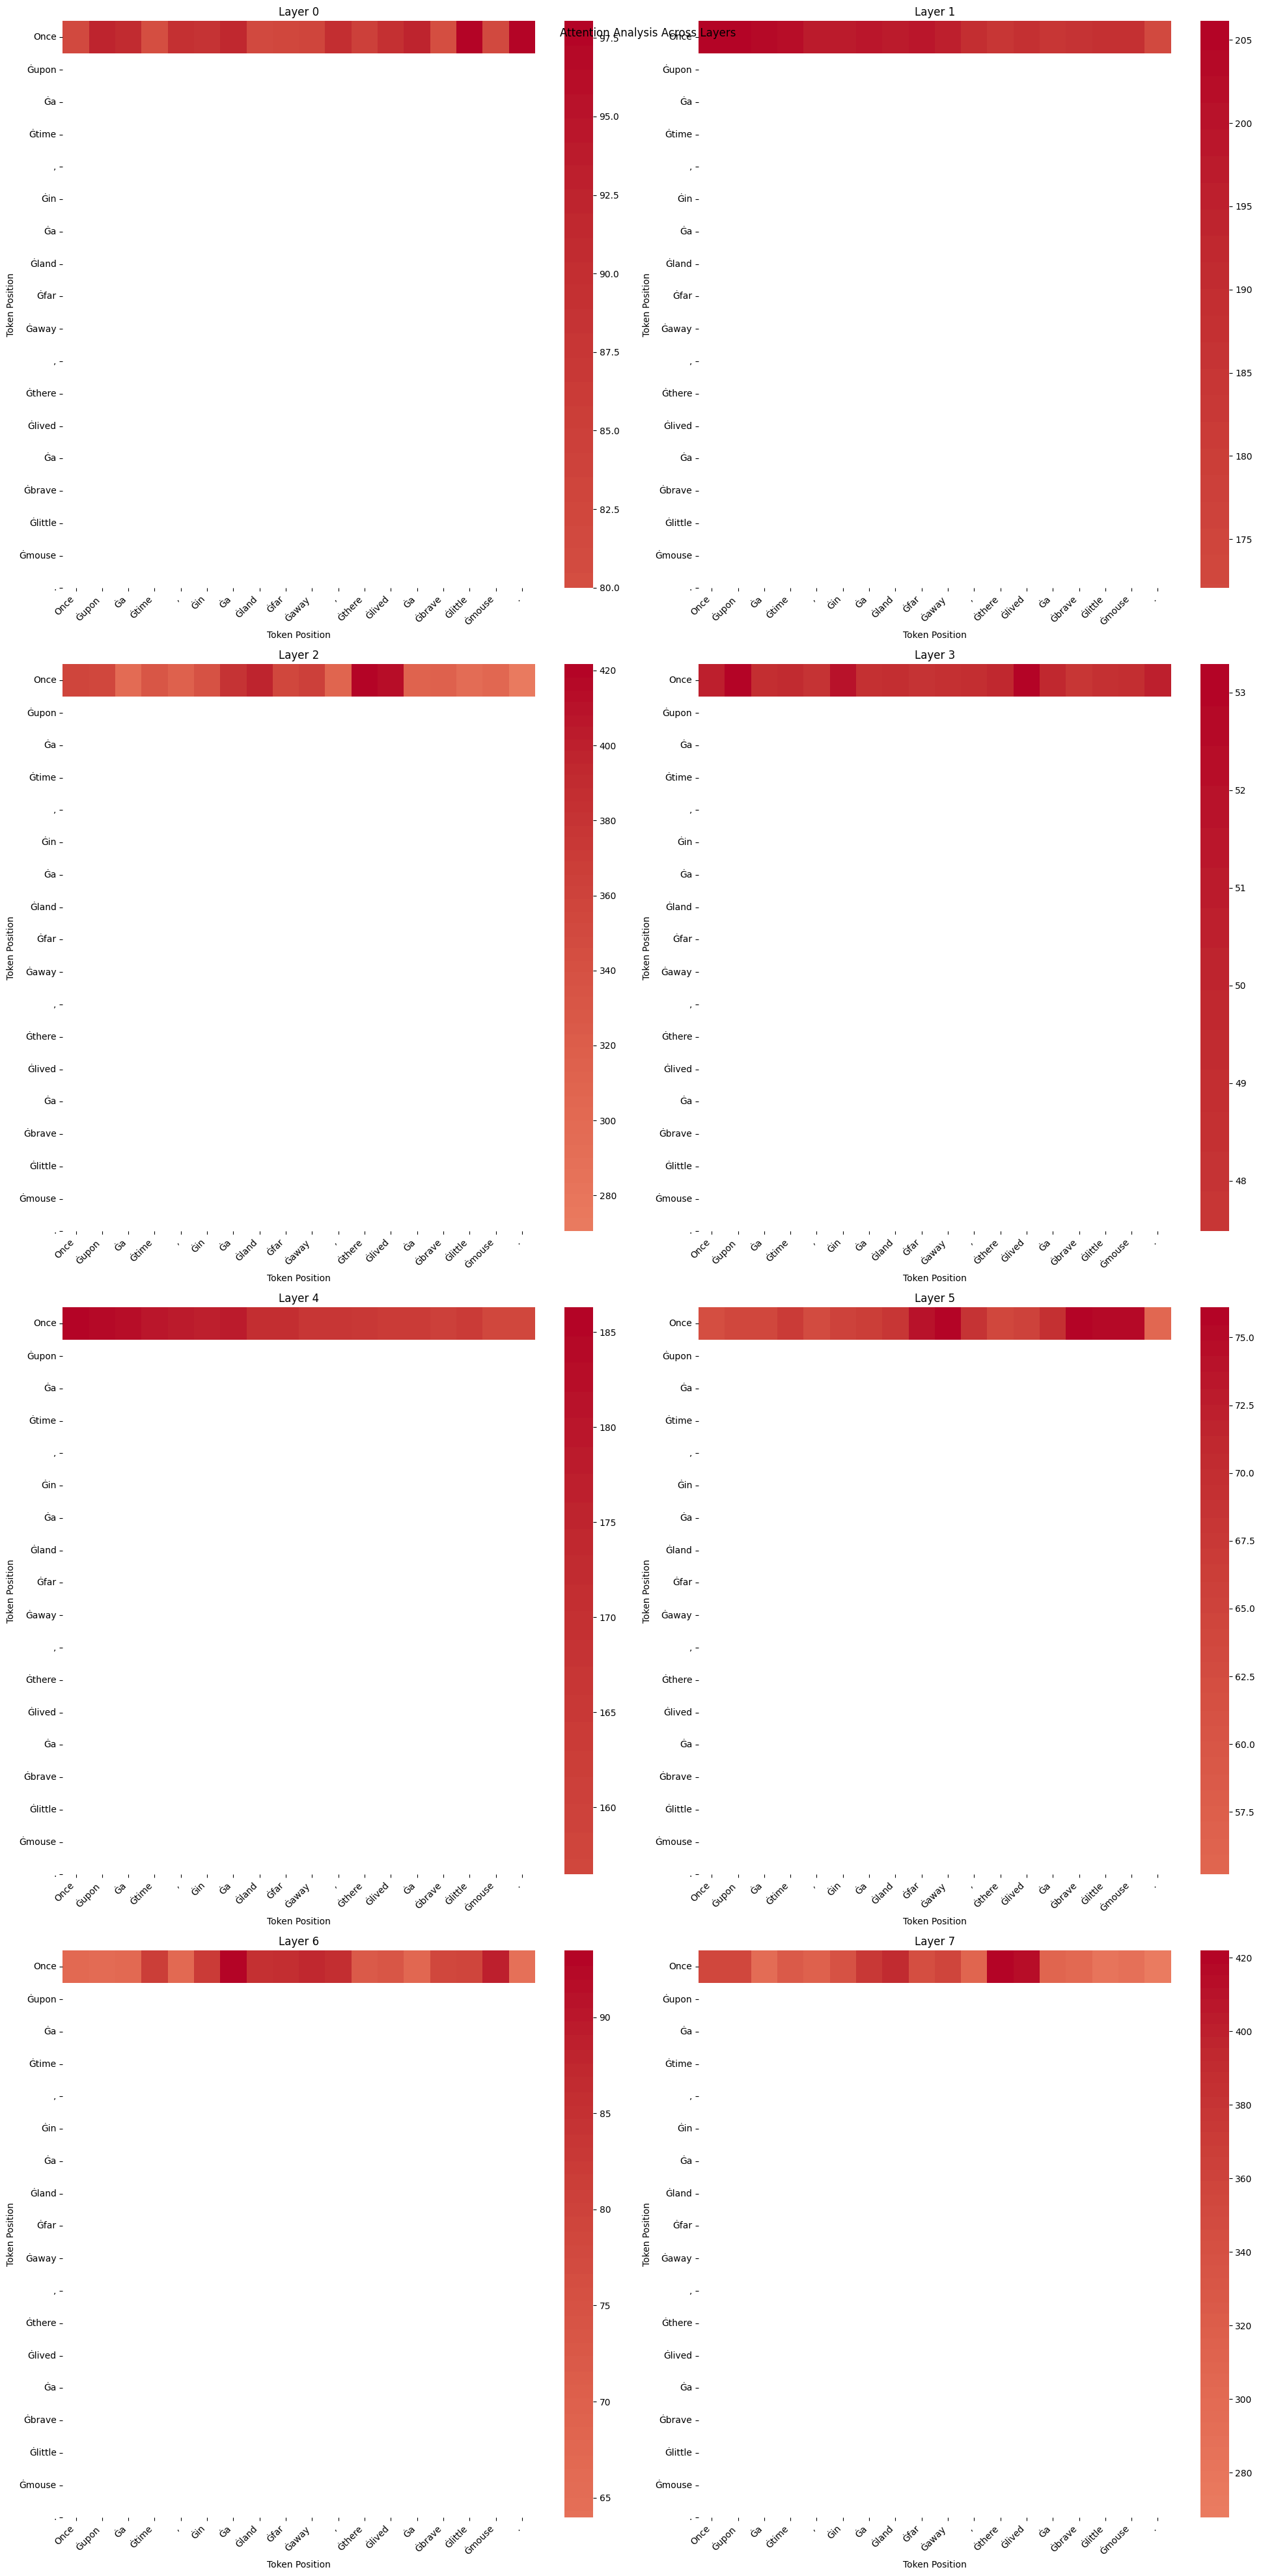

In [40]:
# Attention analysis
attention_inputs, attention_outputs = get_attention_info(model, input_ids)
analyze_attention(attention_inputs, attention_outputs, tokens)


Analyzing MLP Activations:
Layer 0 MLP Activations Shape: torch.Size([1, 18, 128])
Layer 0 MLP Activation Stats:
  Mean: -0.6594
  Std Dev: 18.0370
  Min: -281.4923
  Max: 74.8823


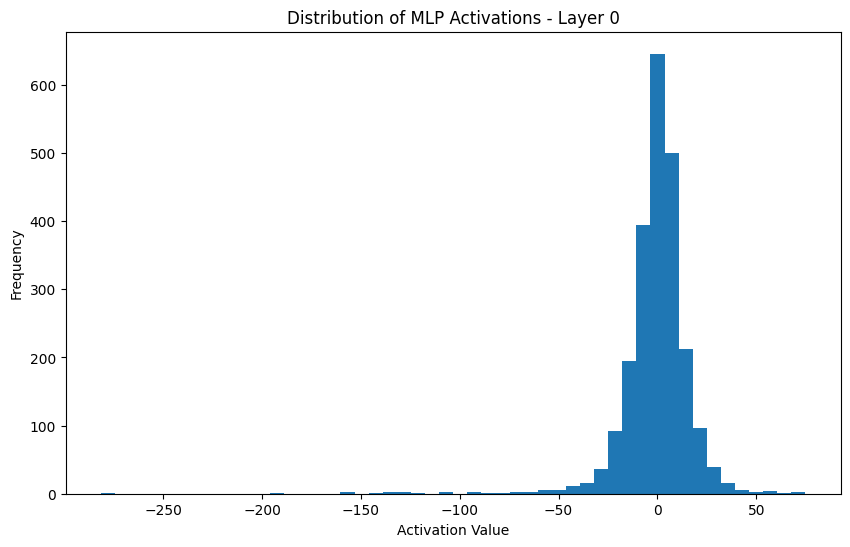

Layer 1 MLP Activations Shape: torch.Size([1, 18, 128])
Layer 1 MLP Activation Stats:
  Mean: -0.6072
  Std Dev: 22.1063
  Min: -257.9722
  Max: 135.0712


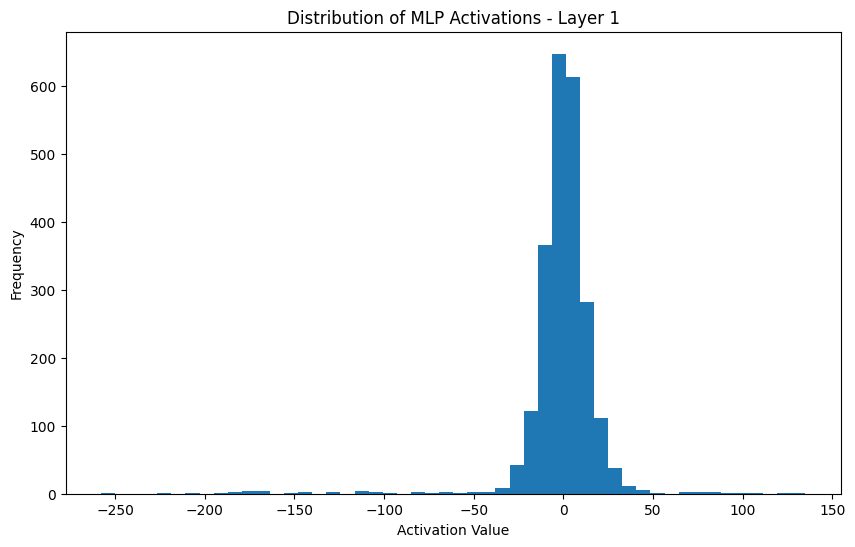

Layer 2 MLP Activations Shape: torch.Size([1, 18, 128])
Layer 2 MLP Activation Stats:
  Mean: -1.0713
  Std Dev: 22.9268
  Min: -264.8662
  Max: 103.0383


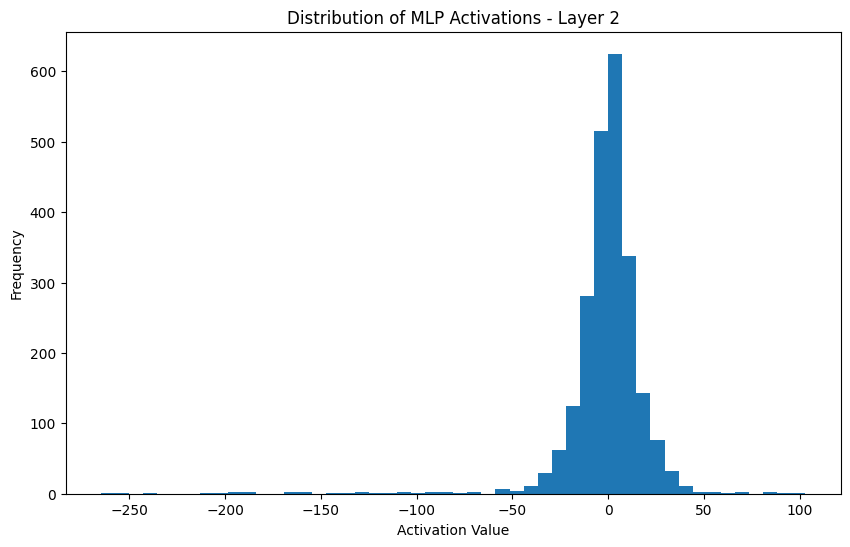

Layer 3 MLP Activations Shape: torch.Size([1, 18, 128])
Layer 3 MLP Activation Stats:
  Mean: -0.5333
  Std Dev: 12.1075
  Min: -144.5981
  Max: 37.8220


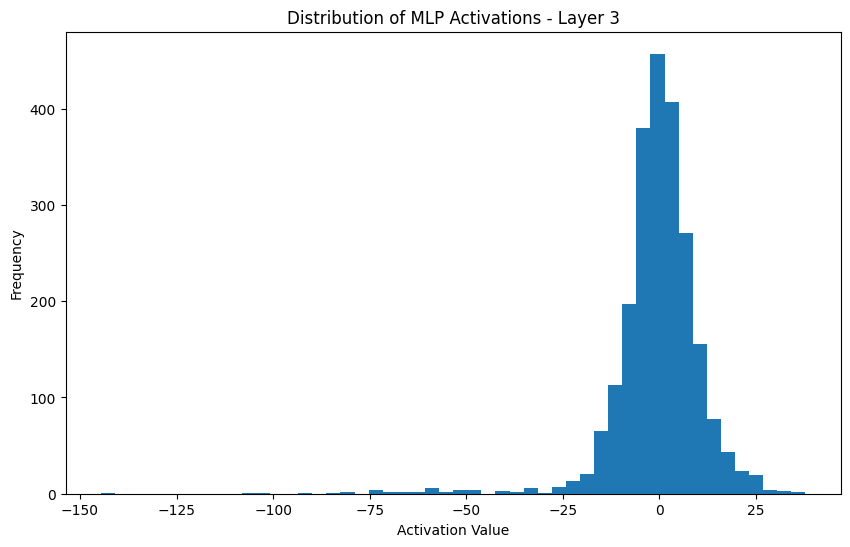

Layer 4 MLP Activations Shape: torch.Size([1, 18, 128])
Layer 4 MLP Activation Stats:
  Mean: 0.0051
  Std Dev: 13.3441
  Min: -97.6192
  Max: 63.8956


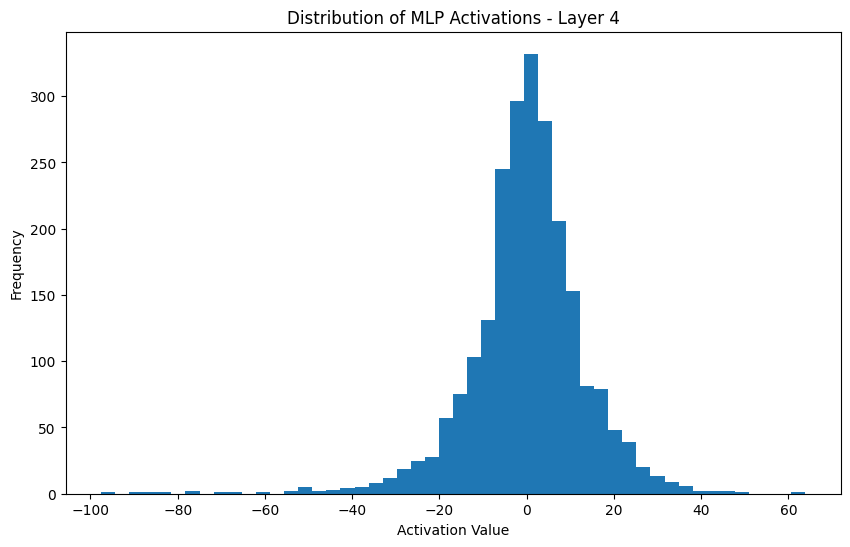

Layer 5 MLP Activations Shape: torch.Size([1, 18, 128])
Layer 5 MLP Activation Stats:
  Mean: -0.0323
  Std Dev: 10.1266
  Min: -69.2825
  Max: 49.5755


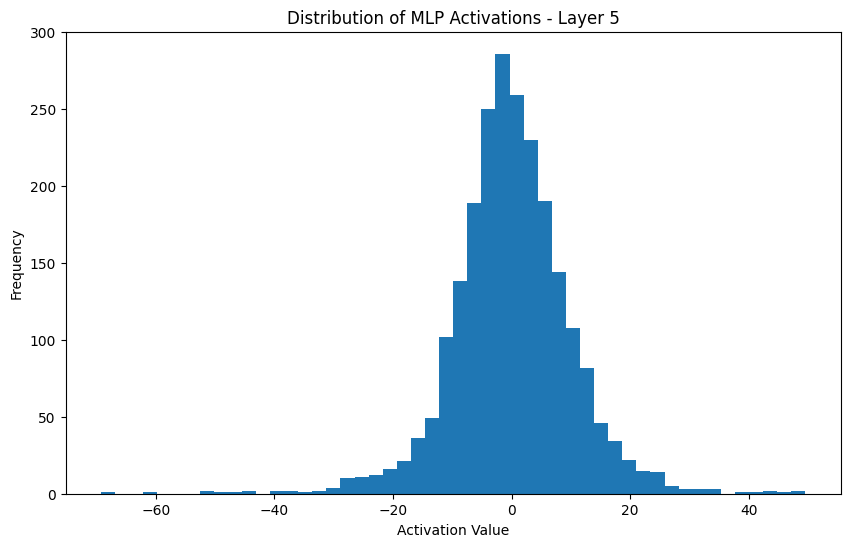

Layer 6 MLP Activations Shape: torch.Size([1, 18, 128])
Layer 6 MLP Activation Stats:
  Mean: -0.0748
  Std Dev: 9.3169
  Min: -37.2437
  Max: 43.0939


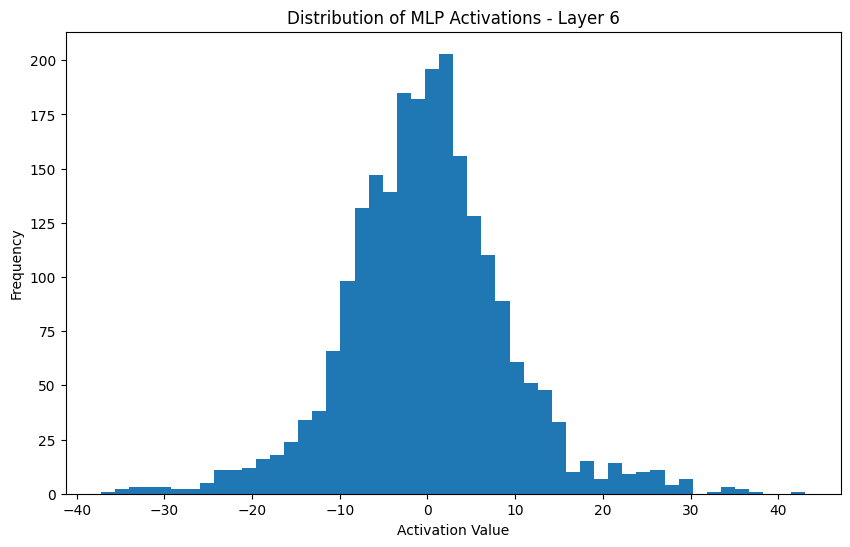

Layer 7 MLP Activations Shape: torch.Size([1, 18, 128])
Layer 7 MLP Activation Stats:
  Mean: 2.9788
  Std Dev: 64.8707
  Min: -426.0629
  Max: 949.9706


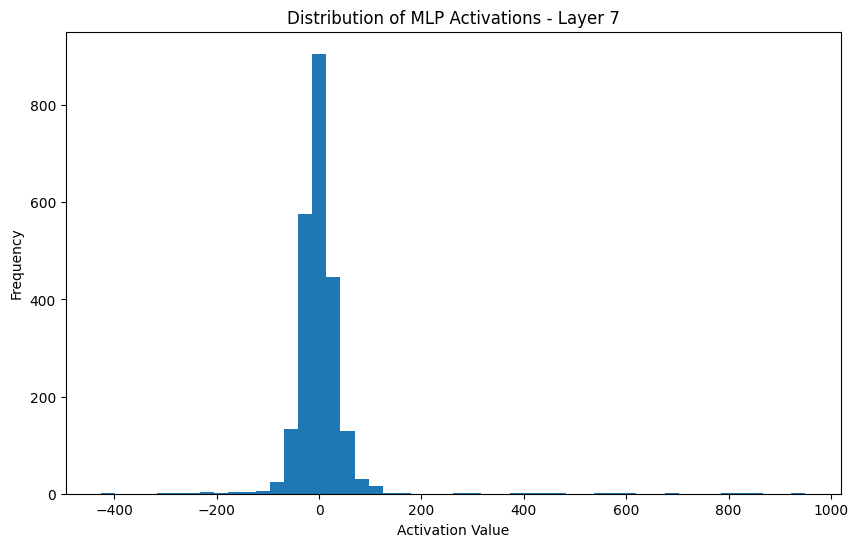


Analyzing Ablation Patterns:
Attention Ablations Shape: (1024, 128)
Neuron Ablations Shape: (4096, 128)


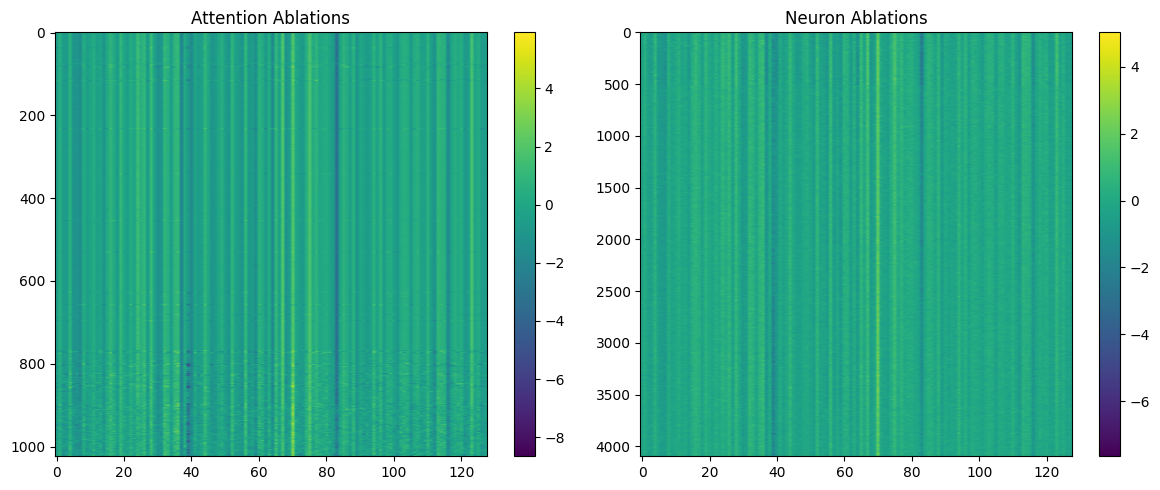


Examining cached activations:
blocks.0.attn: torch.Size([1, 18, 128])
blocks.0.mlp: torch.Size([1, 18, 128])
blocks.1.attn: torch.Size([1, 18, 128])
blocks.1.mlp: torch.Size([1, 18, 128])
blocks.2.attn: torch.Size([1, 18, 128])
blocks.2.mlp: torch.Size([1, 18, 128])
blocks.3.attn: torch.Size([1, 18, 128])
blocks.3.mlp: torch.Size([1, 18, 128])
blocks.4.attn: torch.Size([1, 18, 128])
blocks.4.mlp: torch.Size([1, 18, 128])
blocks.5.attn: torch.Size([1, 18, 128])
blocks.5.mlp: torch.Size([1, 18, 128])
blocks.6.attn: torch.Size([1, 18, 128])
blocks.6.mlp: torch.Size([1, 18, 128])
blocks.7.attn: torch.Size([1, 18, 128])
blocks.7.mlp: torch.Size([1, 18, 128])


In [18]:
# Analysis
print("\nAnalyzing MLP Activations:")
analyze_mlp_activations(hook_data)

print("\nAnalyzing Ablation Patterns:")
analyze_ablations(model)

print("\nExamining cached activations:")
for name, activation in cache.items():
    print(f"{name}: {activation.shape}")

## CircuitViz Visualizations (Attempted)
So far it requires more compatible implementation of the wrapper with the pre-loaded models in transformer_lens <br />
Feasibility: Unknown

In [41]:
import einops 
import torch as t
from torch import Tensor
import circuitsvis as cv
from jaxtyping import Float
from IPython.display import clear_output, display, HTML
from transformer_lens import HookedTransformer

In [42]:
# Model loading

t.set_grad_enabled(False)
# Load the pre-trained model
config = GPTNeoConfig(hidden_size=128)
model = GPTNeo(config)
model.load_state_dict(torch.load('best_model_128width_120000batches.pt', map_location=torch.device('cpu')))
model.eval()
wrapped_model = PreTrainedGPTNeoWrapper(model)

/home/jazhyc/miniconda3/envs/ablation/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [43]:
gpt_neo_c = wrapped_model
input_text = "Once upon a time, in a land far away, there lived a brave little mouse."

input_ids = gpt_neo_c.tokenizer(input_text, return_tensors="pt").input_ids

In [44]:
names_filter = lambda name: any(name.endswith(f"hook_{s}") for s in ["pattern", "q", "k", "v"])
logits, cache = gpt_neo_c.run_with_cache(input_ids)

places where ablation_mask is nonzero: [[0, 0, 76], [0, 0, 79], [0, 1, 76], [0, 2, 76], [0, 2, 127], [0, 3, 76], [0, 3, 84], [0, 3, 117], [0, 4, 76], [0, 5, 65], [0, 5, 76], [0, 6, 76], [0, 7, 65], [0, 7, 76], [0, 7, 84], [0, 8, 65], [0, 8, 76], [0, 9, 65], [0, 9, 76], [0, 10, 65], [0, 10, 76], [0, 11, 76], [0, 11, 84], [0, 12, 76], [0, 12, 84], [0, 12, 117], [0, 13, 76], [0, 13, 84], [0, 13, 115], [0, 14, 74], [0, 14, 76], [0, 14, 84], [0, 14, 115], [0, 15, 76], [0, 15, 115], [0, 16, 76], [0, 16, 115], [0, 16, 127], [0, 17, 4], [0, 17, 15], [0, 17, 65], [0, 17, 74], [0, 17, 76], [0, 17, 86], [0, 17, 92], [0, 17, 97], [0, 17, 127]]
places where ablation_mask is nonzero: [[0, 2, 104], [0, 17, 106]]
places where ablation_mask is nonzero: []
places where ablation_mask is nonzero: [[0, 2, 71], [0, 3, 71], [0, 6, 71], [0, 13, 71], [0, 14, 71], [0, 15, 71], [0, 16, 71], [0, 17, 71]]
places where ablation_mask is nonzero: [[0, 8, 19], [0, 13, 19], [0, 14, 19], [0, 15, 19]]
places where ablati

In [45]:
cache.keys()

dict_keys(['blocks.0.attn', 'blocks.0.mlp', 'blocks.1.attn', 'blocks.1.mlp', 'blocks.2.attn', 'blocks.2.mlp', 'blocks.3.attn', 'blocks.3.mlp', 'blocks.4.attn', 'blocks.4.mlp', 'blocks.5.attn', 'blocks.5.mlp', 'blocks.6.attn', 'blocks.6.mlp', 'blocks.7.attn', 'blocks.7.mlp', 'attention ablations', 'mlp ablations'])

In [52]:
_attention = cache['attention ablations']
_tokens = gpt_neo_c.tokenizer.convert_ids_to_tokens(input_ids[0])

cv.attention.attention_pattern(
    attention = _attention,
    tokens = _tokens,
)

## Draft version of experiment 1

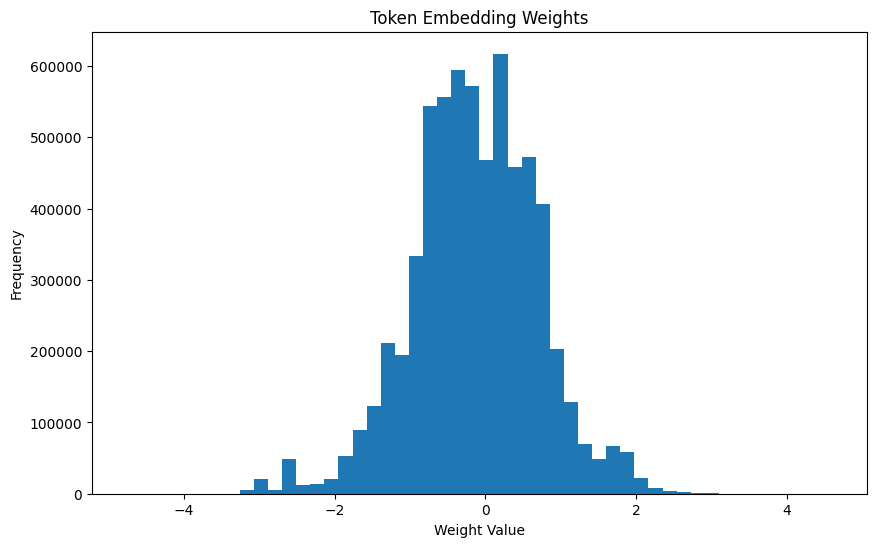

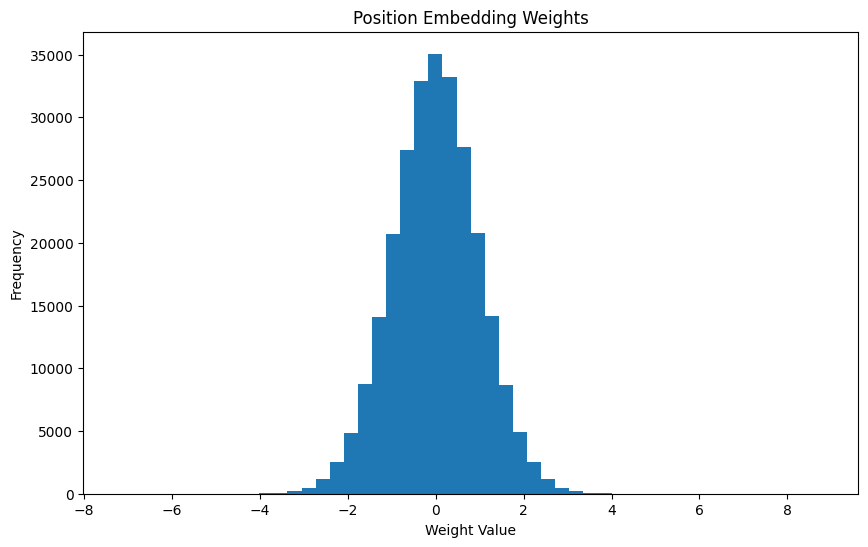

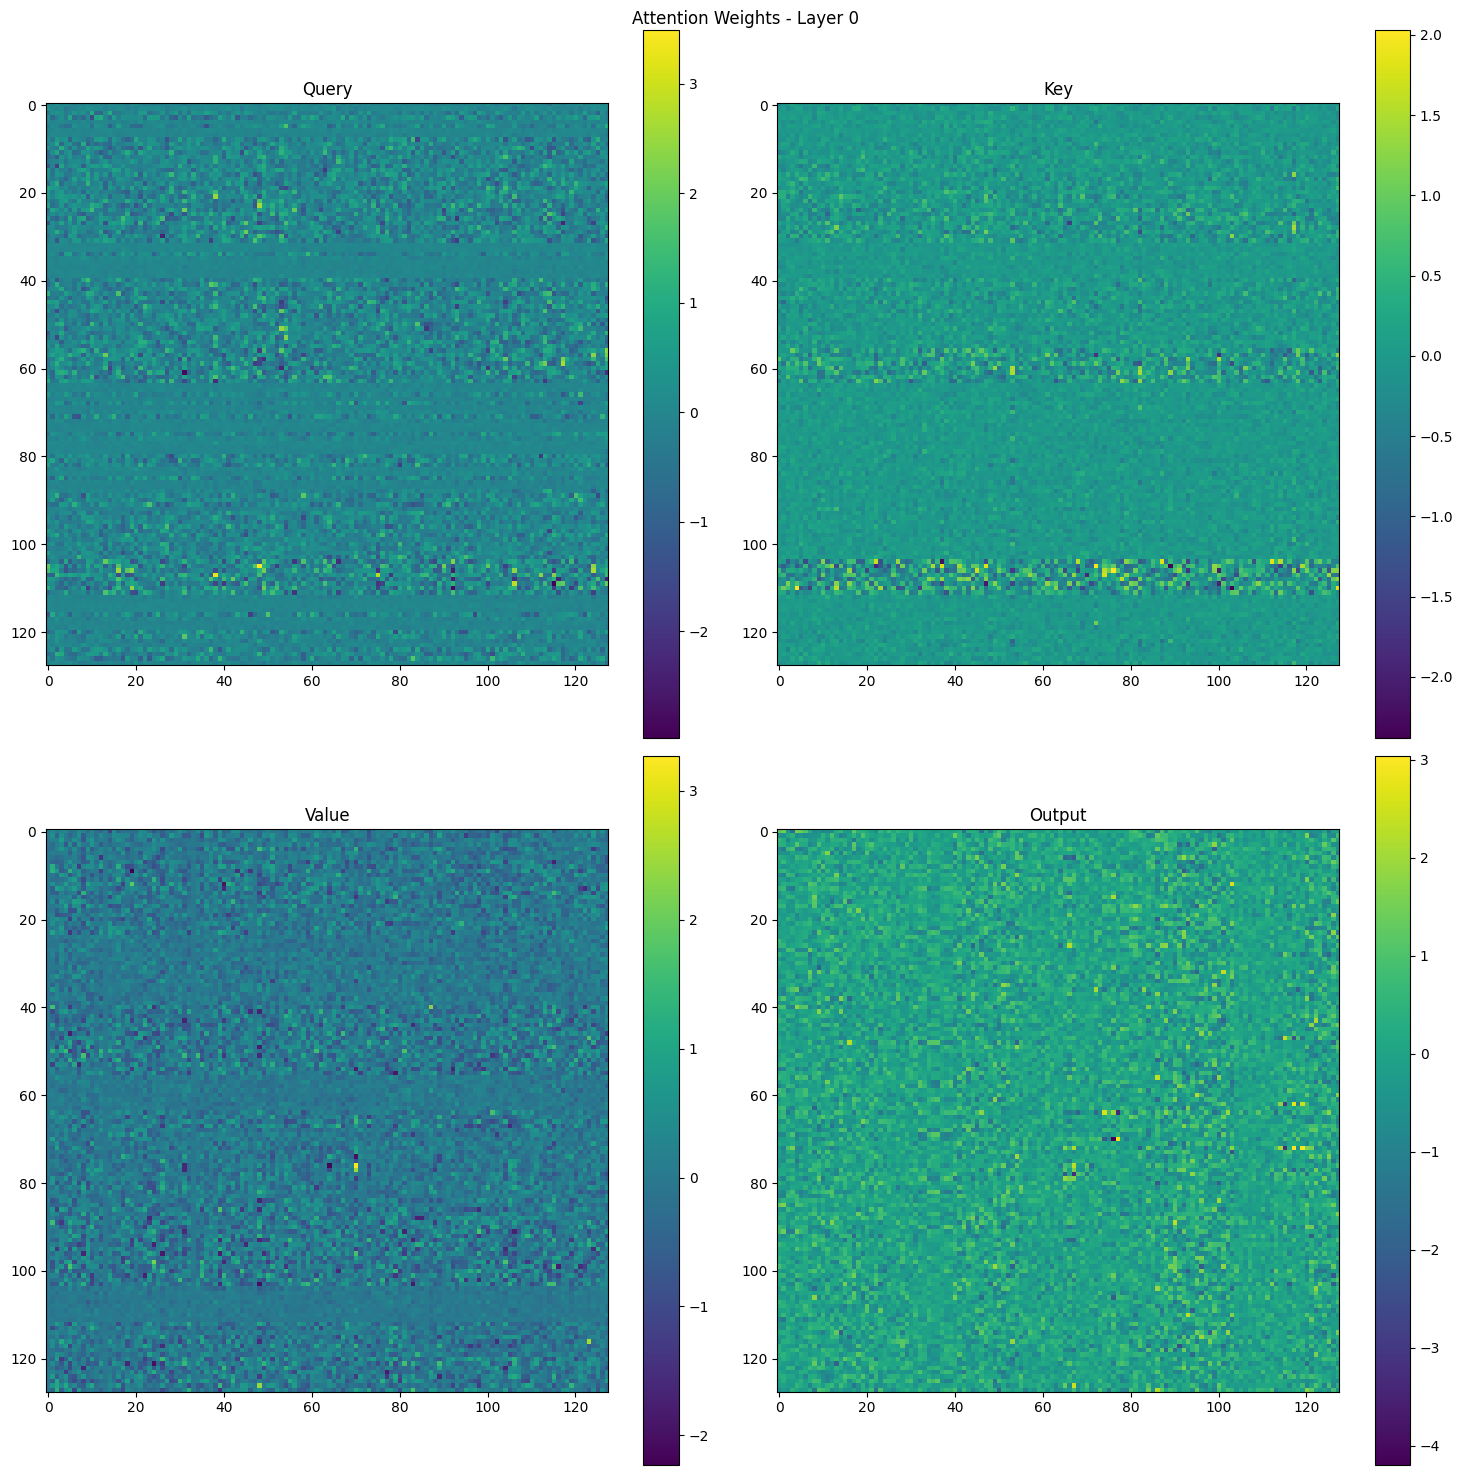

MLP Analysis - Layer 0
Input dimension: 128
Hidden dimension: 512
Output dimension: 128


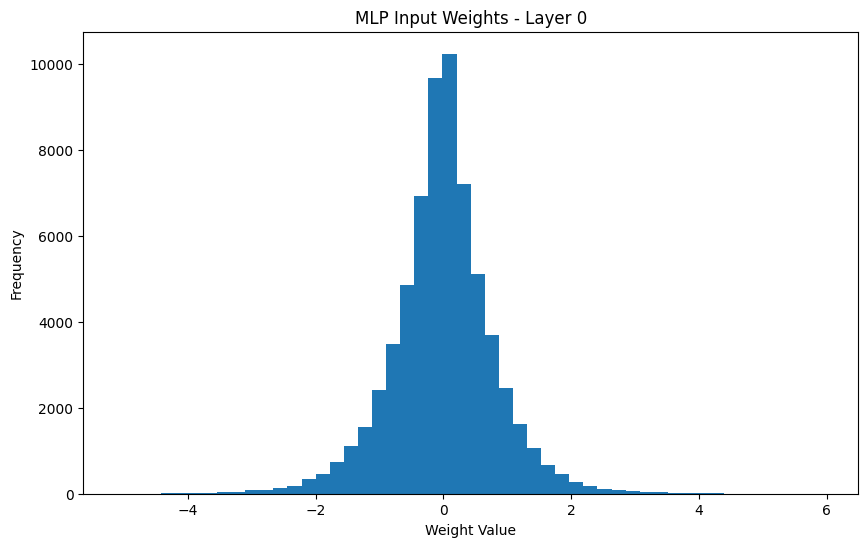

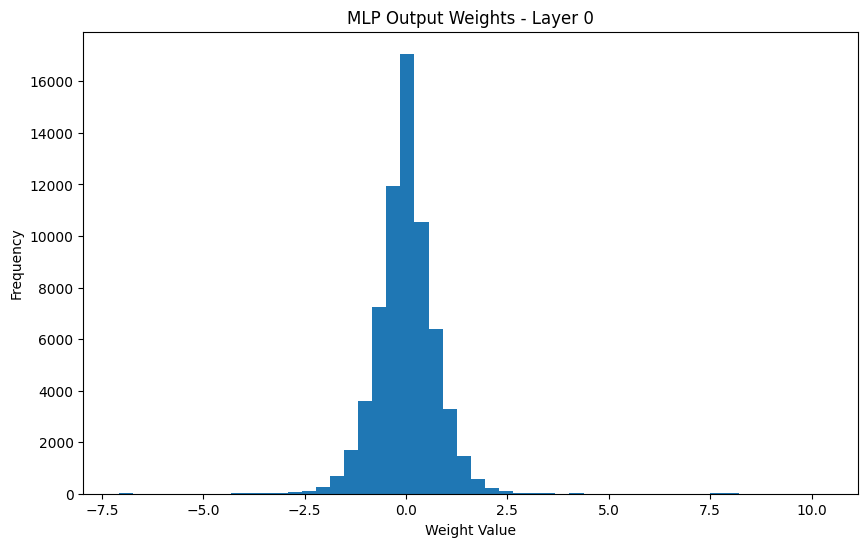

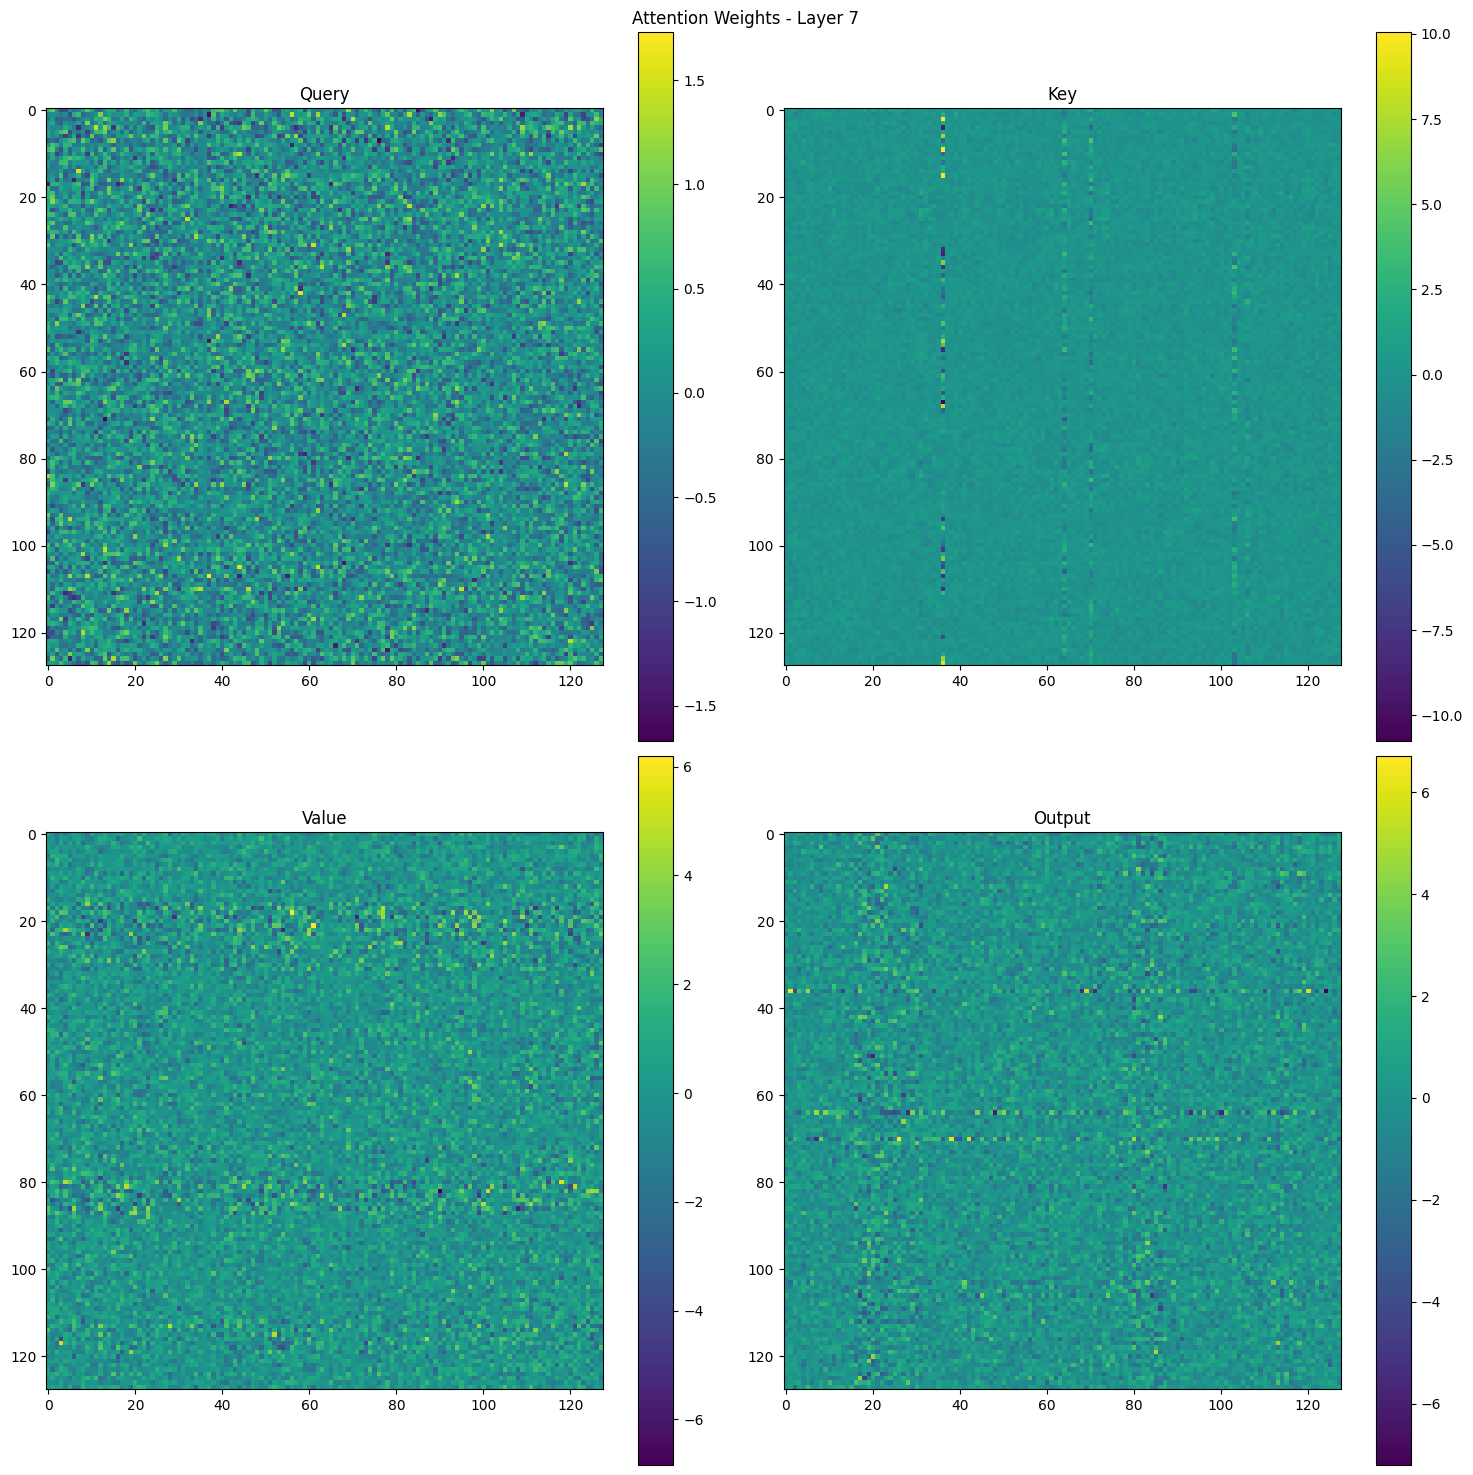

MLP Analysis - Layer 7
Input dimension: 128
Hidden dimension: 512
Output dimension: 128


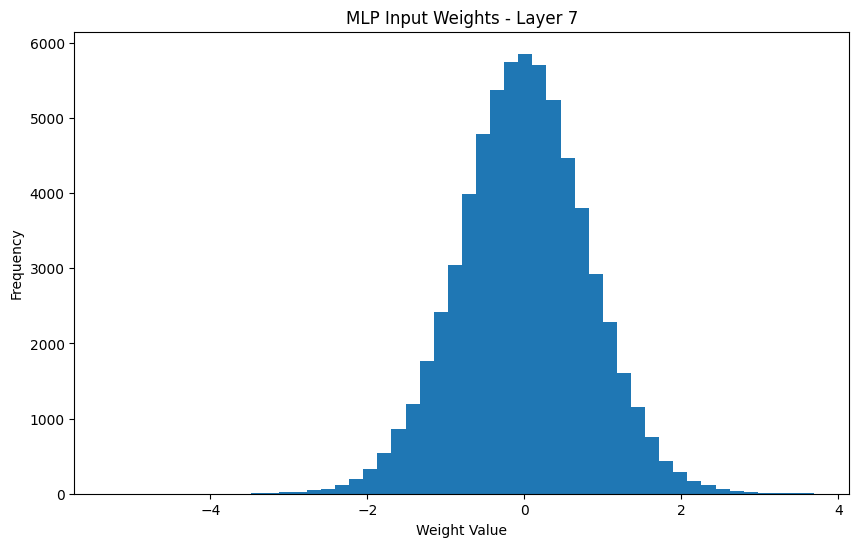

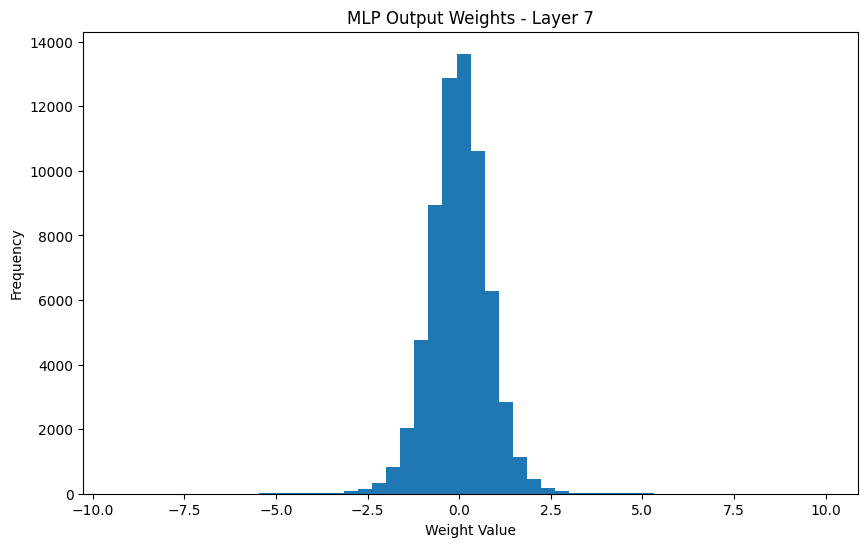

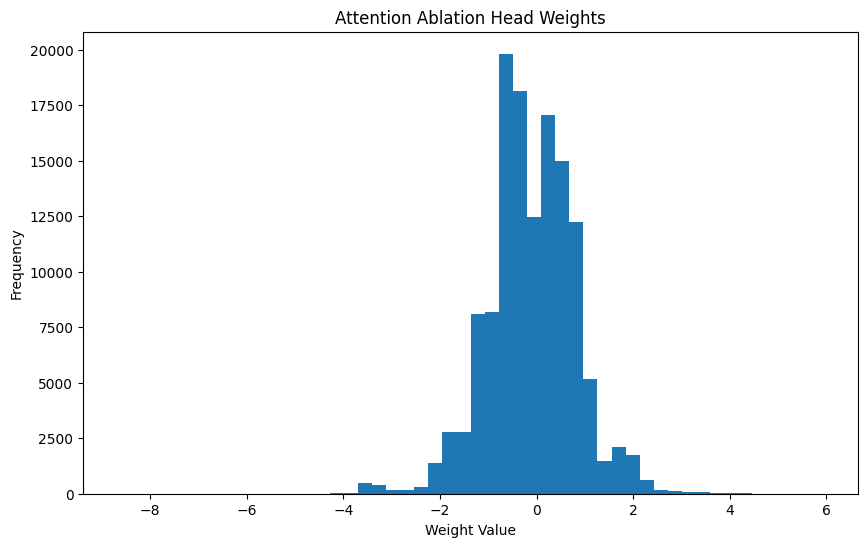

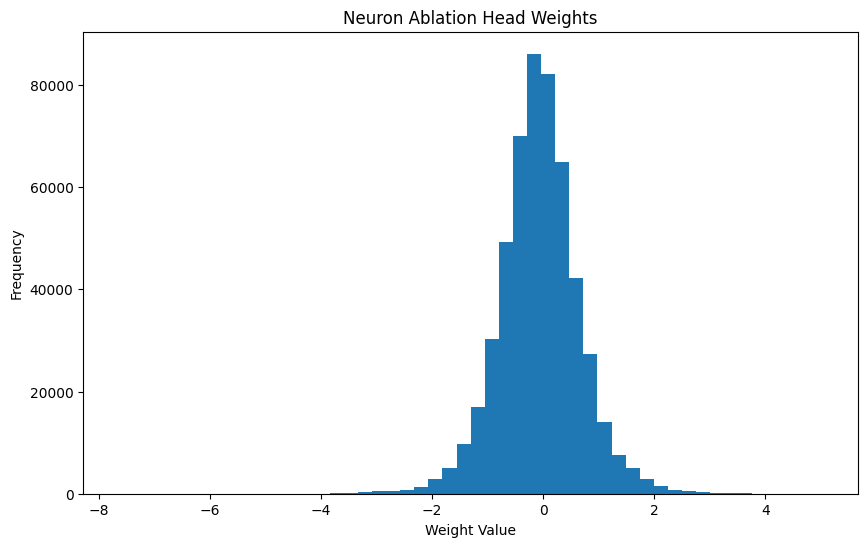

Analysis complete. Check the generated plots for visualizations.


In [24]:

def visualize_weight_distribution(weight, title):
    """Visualize the distribution of weights in a parameter."""
    plt.figure(figsize=(10, 6))
    plt.hist(weight.detach().cpu().numpy().flatten(), bins=50)
    plt.title(title)
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()

def visualize_attention_weights(model, layer_idx):
    """Visualize attention weights for a specific layer."""
    attention = model.transformer.h[layer_idx].attn.attention
    weights = {
        'Query': attention.q_proj.weight,
        'Key': attention.k_proj.weight,
        'Value': attention.v_proj.weight,
        'Output': attention.out_proj.weight
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(f'Attention Weights - Layer {layer_idx}')
    
    for (name, weight), ax in zip(weights.items(), axes.flatten()):
        im = ax.imshow(weight.detach().cpu().numpy(), cmap='viridis')
        ax.set_title(name)
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

def analyze_mlp(model, layer_idx):
    """Analyze the MLP of a specific layer."""
    mlp = model.transformer.h[layer_idx].mlp
    print(f"MLP Analysis - Layer {layer_idx}")
    print(f"Input dimension: {mlp.c_fc.in_features}")
    print(f"Hidden dimension: {mlp.c_fc.out_features}")
    print(f"Output dimension: {mlp.c_proj.out_features}")
    
    visualize_weight_distribution(mlp.c_fc.weight, f'MLP Input Weights - Layer {layer_idx}')
    visualize_weight_distribution(mlp.c_proj.weight, f'MLP Output Weights - Layer {layer_idx}')

# Analyze embedding weights
visualize_weight_distribution(model.transformer.wte.weight, 'Token Embedding Weights')
visualize_weight_distribution(model.transformer.wpe.weight, 'Position Embedding Weights')

# Analyze attention and MLP for the first and last layers
for layer_idx in [0, 7]:  # First and last layers
    visualize_attention_weights(model, layer_idx)
    analyze_mlp(model, layer_idx)

# Analyze ablation heads
visualize_weight_distribution(model.attention_ablations_head.weight, 'Attention Ablation Head Weights')
visualize_weight_distribution(model.neuron_ablations_head.weight, 'Neuron Ablation Head Weights')

print("Analysis complete. Check the generated plots for visualizations.")

/var/folders/f5/t4n8wk5d419dcc_kskpqnt800000gn/T/ipykernel_16906/2704501891.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

places where ablation_mask is nonzero: [[0, 0, 76], [0, 0, 79], [0, 1, 76], [0, 2, 76], [0, 2, 127], [0, 3, 76], [0, 3, 84], [0, 3, 117]]
places where ablation_mask is nonzero: [[0, 2, 104]]
places where ablation_mask is nonzero: []
places where ablation_mask is nonzero: [[0, 2, 71], [0, 3, 71]]
places where ablation_mask is nonzero: []
places where ablation_mask is nonzero: []
places where ablation_mask is nonzero: [[0, 0, 2], [0, 0, 100], [0, 2, 2], [0, 2, 59], [0, 3, 7], [0, 3, 100], [0, 3, 116]]
places where ablation_mask is nonzero: [[0, 0, 3], [0, 0, 19], [0, 0, 20], [0, 0, 21], [0, 0, 30], [0, 0, 31], [0, 0, 42], [0, 0, 47], [0, 0, 71], [0, 0, 79], [0, 0, 92], [0, 0, 94], [0, 0, 113], [0, 0, 122], [0, 1, 19], [0, 1, 87], [0, 1, 92], [0, 1, 113], [0, 2, 0], [0, 2, 3], [0, 2, 5], [0, 2, 10], [0, 2, 16], [0, 2, 18], [0, 2, 19], [0, 2, 20], [0, 2, 21], [0, 2, 22], [0, 2, 24], [0, 2, 26], [0, 2, 29], [0, 2, 43], [0, 2, 48], [0, 2, 65], [0, 2, 70], [0, 2, 71], [0, 2, 78], [0, 2, 79], 

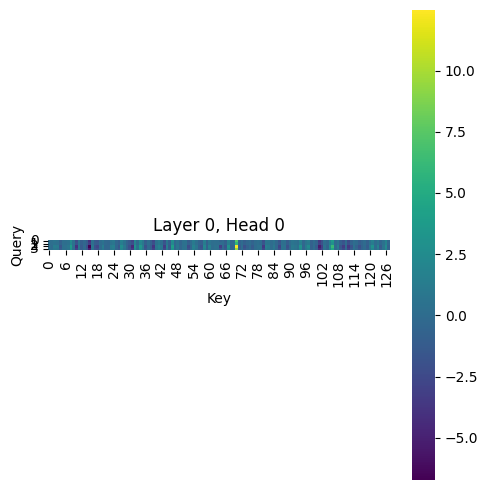

Layer 1 Attention Output Type: <class 'torch.Tensor'>
Layer 1 Attention Output Shape: torch.Size([1, 4, 128])


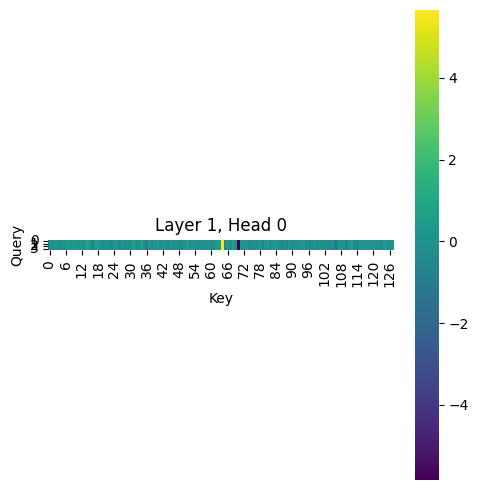

Layer 2 Attention Output Type: <class 'torch.Tensor'>
Layer 2 Attention Output Shape: torch.Size([1, 4, 128])


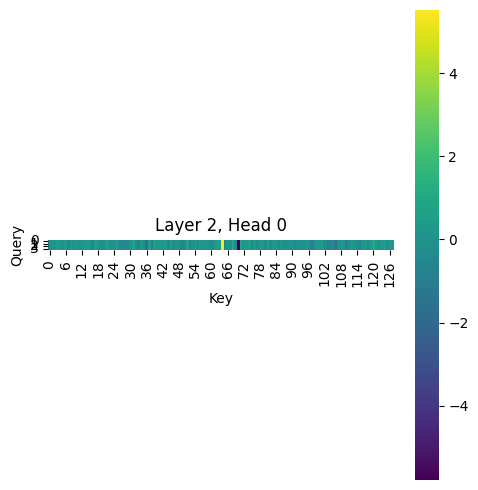

Layer 3 Attention Output Type: <class 'torch.Tensor'>
Layer 3 Attention Output Shape: torch.Size([1, 4, 128])


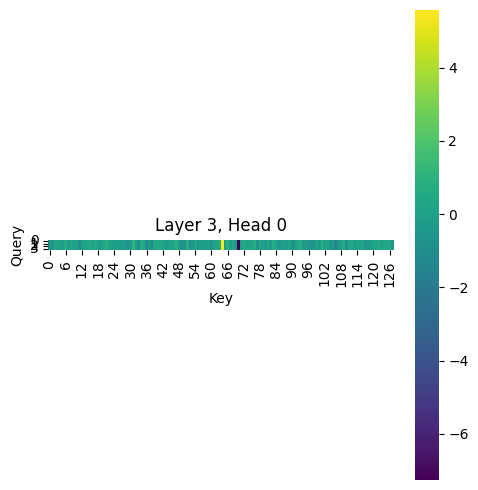

Layer 4 Attention Output Type: <class 'torch.Tensor'>
Layer 4 Attention Output Shape: torch.Size([1, 4, 128])


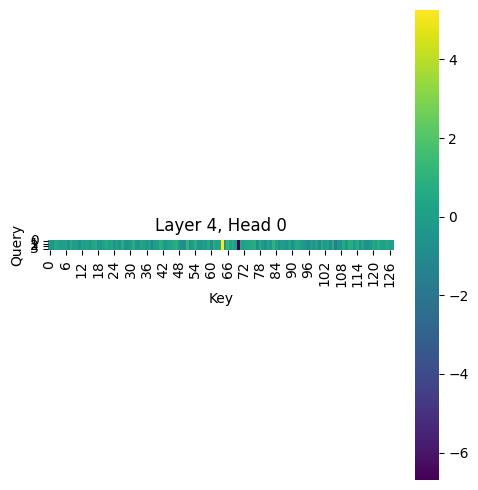

Layer 5 Attention Output Type: <class 'torch.Tensor'>
Layer 5 Attention Output Shape: torch.Size([1, 4, 128])


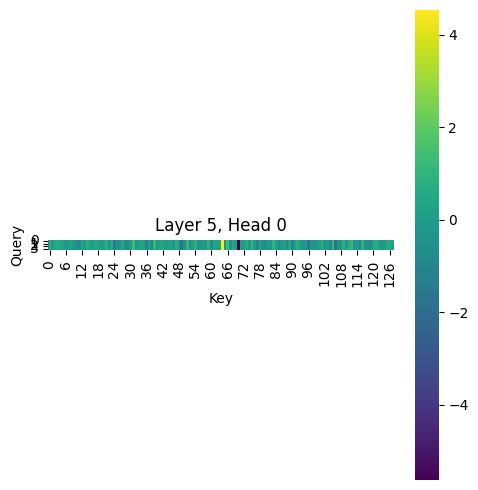

Layer 6 Attention Output Type: <class 'torch.Tensor'>
Layer 6 Attention Output Shape: torch.Size([1, 4, 128])


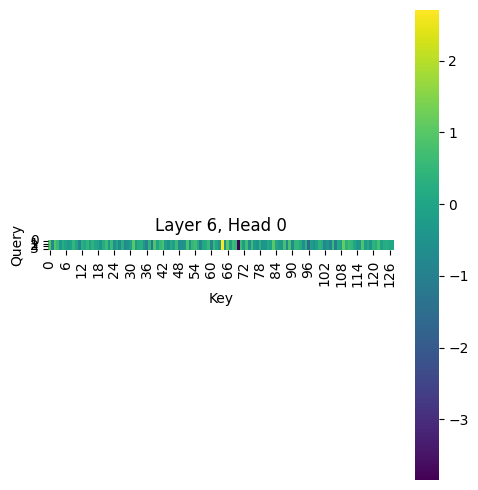

Layer 7 Attention Output Type: <class 'torch.Tensor'>
Layer 7 Attention Output Shape: torch.Size([1, 4, 128])


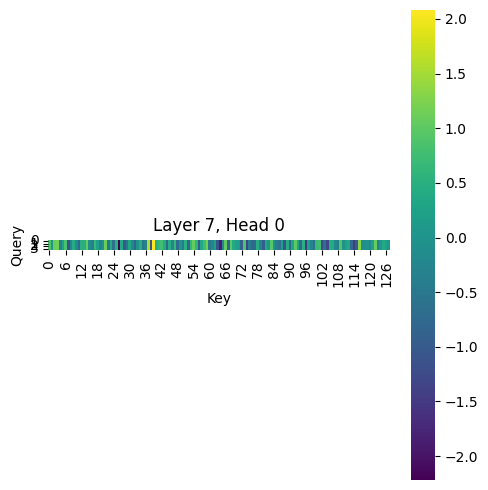


Analyzing MLP Activations:
Layer 0 MLP Activations Shape: torch.Size([1, 4, 128])
Layer 0 MLP Activation Stats:
  Mean: -0.3775
  Std Dev: 9.5131
  Min: -91.4325
  Max: 34.2279


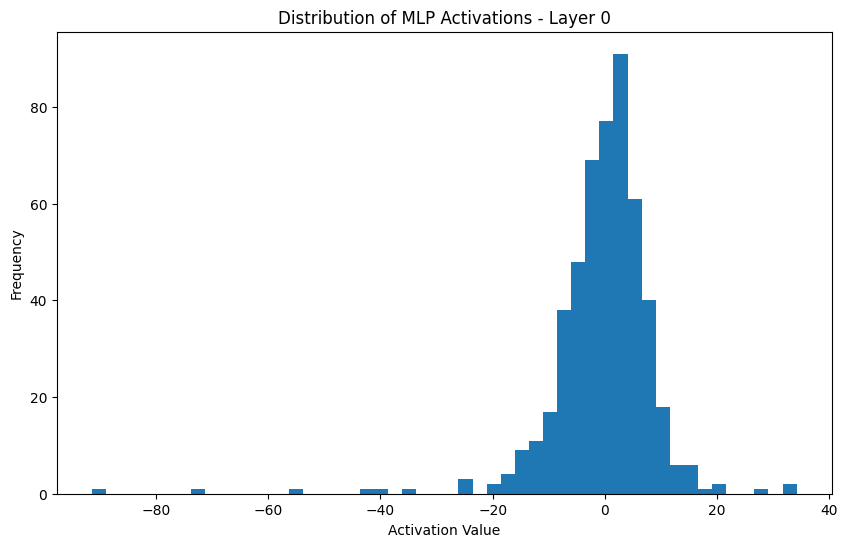

Layer 1 MLP Activations Shape: torch.Size([1, 4, 128])
Layer 1 MLP Activation Stats:
  Mean: -0.3345
  Std Dev: 13.1445
  Min: -141.9754
  Max: 81.2478


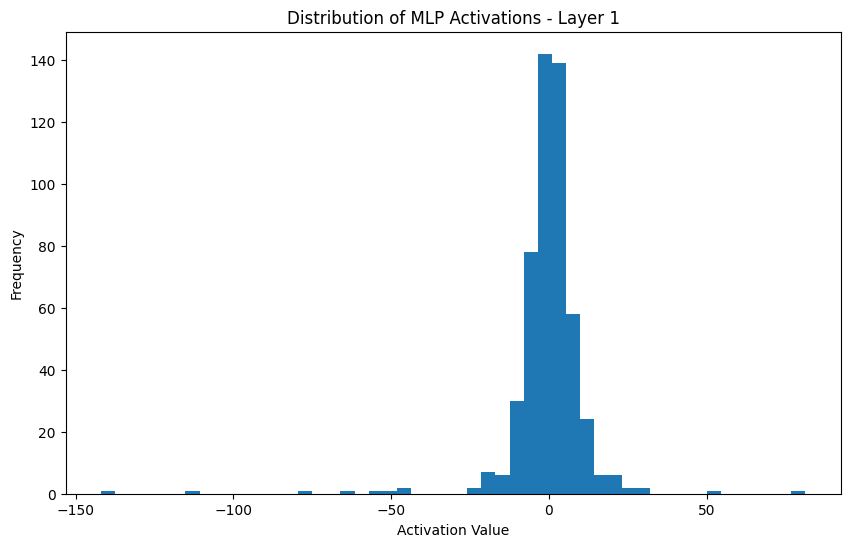

Layer 2 MLP Activations Shape: torch.Size([1, 4, 128])
Layer 2 MLP Activation Stats:
  Mean: -0.5779
  Std Dev: 11.9063
  Min: -98.5052
  Max: 41.8011


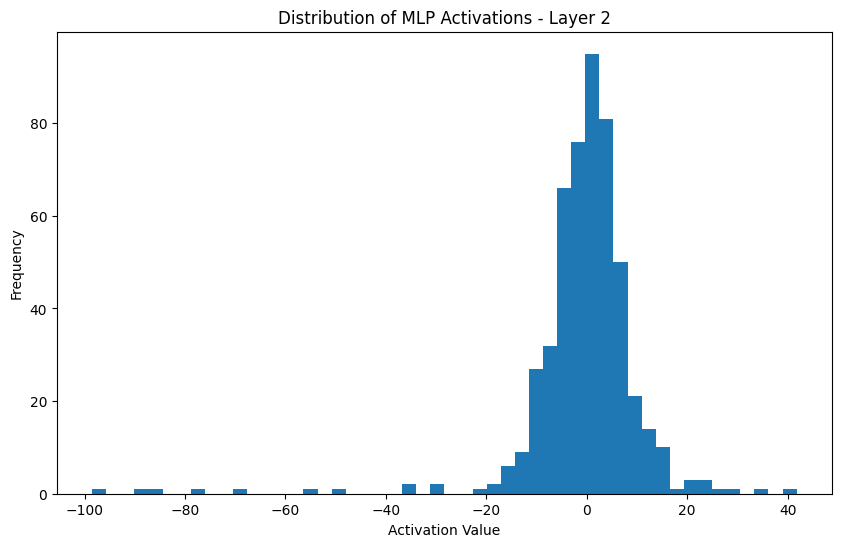

Layer 3 MLP Activations Shape: torch.Size([1, 4, 128])
Layer 3 MLP Activation Stats:
  Mean: -0.5033
  Std Dev: 10.8872
  Min: -107.0511
  Max: 24.4853


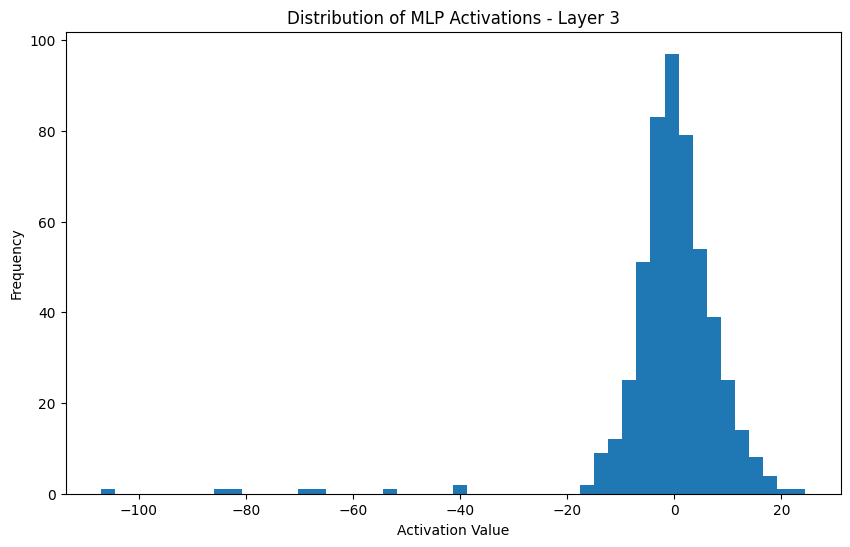

Layer 4 MLP Activations Shape: torch.Size([1, 4, 128])
Layer 4 MLP Activation Stats:
  Mean: 0.0021
  Std Dev: 7.6051
  Min: -51.9969
  Max: 26.9494


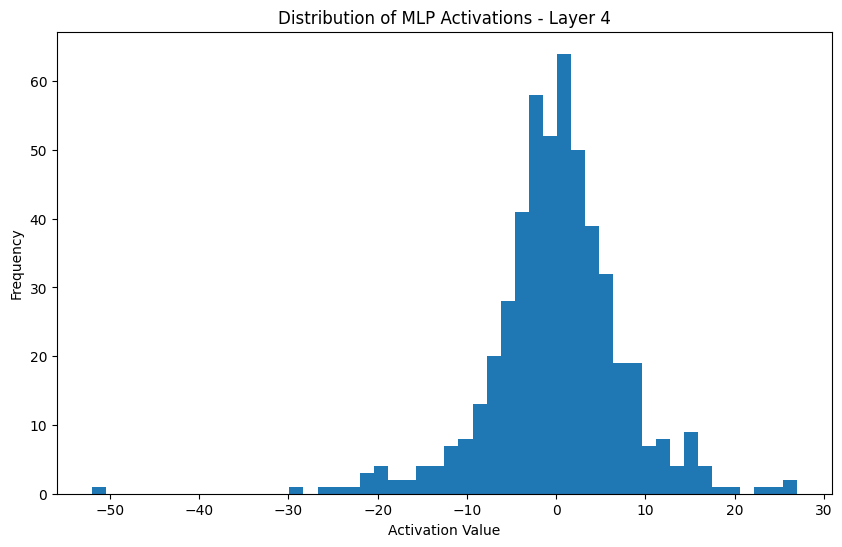

Layer 5 MLP Activations Shape: torch.Size([1, 4, 128])
Layer 5 MLP Activation Stats:
  Mean: -0.0686
  Std Dev: 6.1314
  Min: -36.1769
  Max: 24.1865


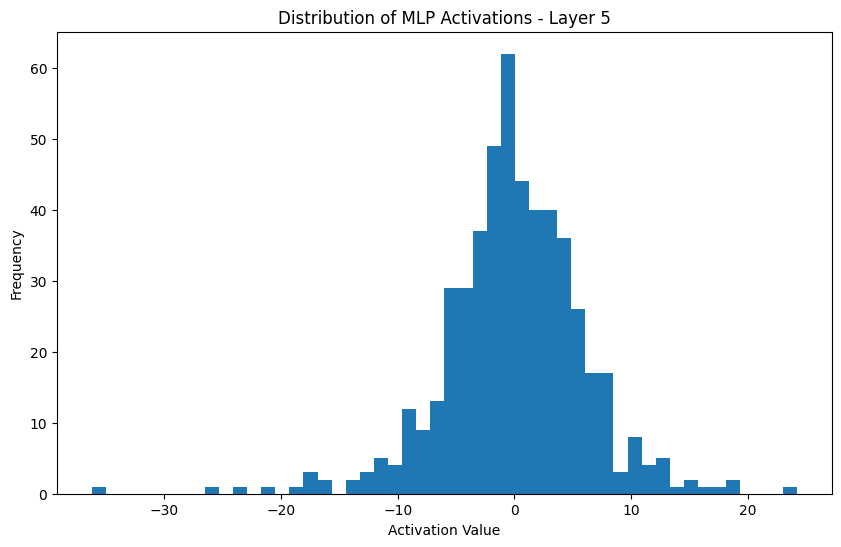

Layer 6 MLP Activations Shape: torch.Size([1, 4, 128])
Layer 6 MLP Activation Stats:
  Mean: -0.1166
  Std Dev: 8.4425
  Min: -33.6911
  Max: 36.1603


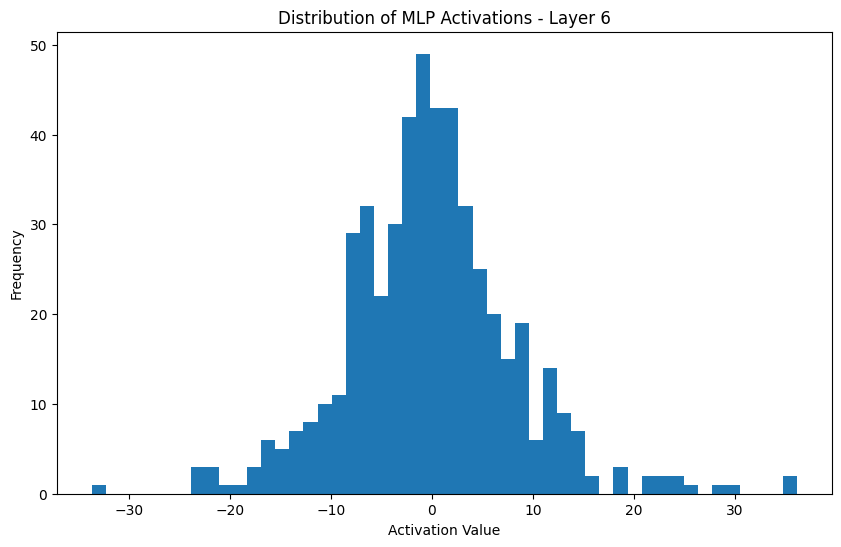

Layer 7 MLP Activations Shape: torch.Size([1, 4, 128])
Layer 7 MLP Activation Stats:
  Mean: 1.9908
  Std Dev: 43.9231
  Min: -204.5060
  Max: 609.1213


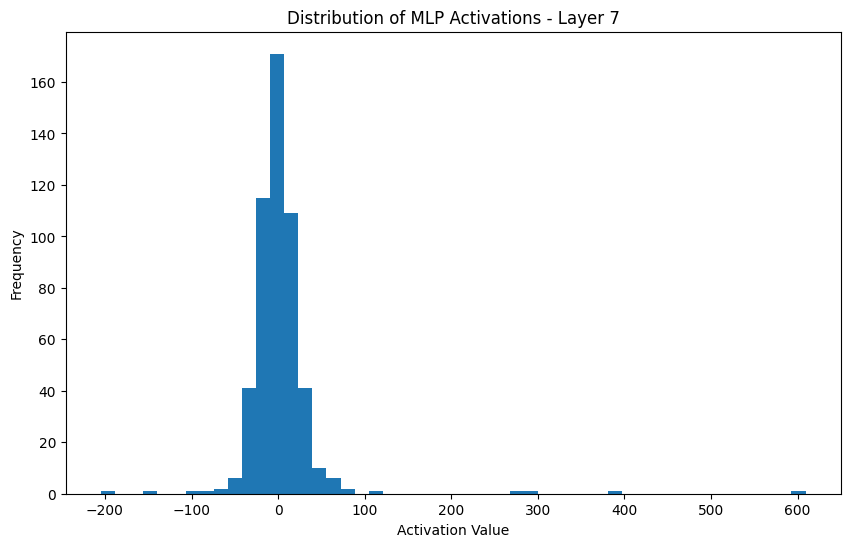


Analyzing Ablation Patterns:
Attention Ablations Shape: (1024, 128)
Neuron Ablations Shape: (4096, 128)


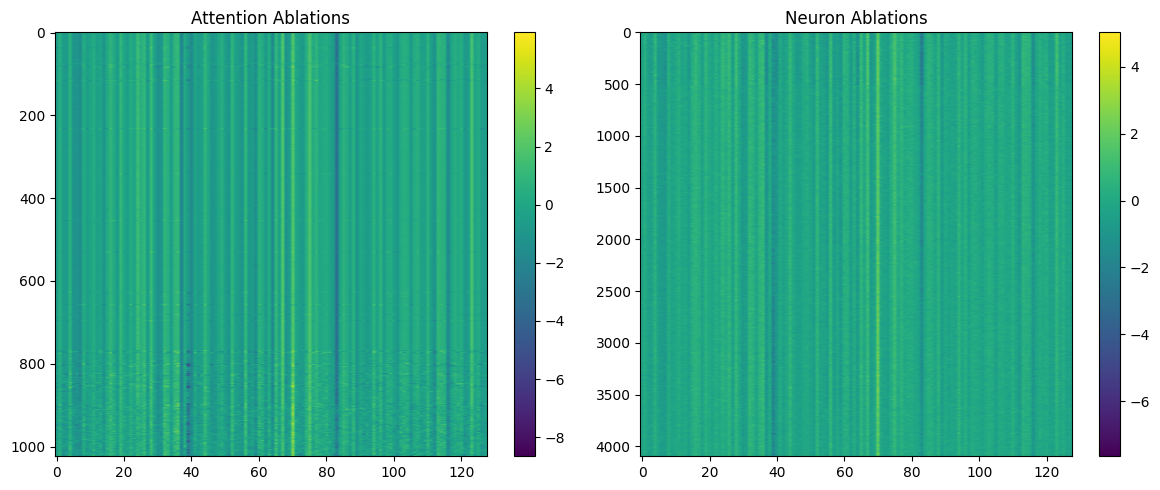

In [25]:
import torch
from transformers import GPT2Tokenizer
from transformer_lens import HookedTransformer, HookedTransformerConfig
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ... [Previous code for PreTrainedGPTNeoWrapper remains the same] ...

# Load the pre-trained model
config = GPTNeoConfig(hidden_size=128)
model = GPTNeo(config)
model.load_state_dict(torch.load('best_model_128width_120000batches.pt', map_location=torch.device('cpu')))
model.eval()

# Initialize the wrapper with the pre-trained model
wrapped_model = PreTrainedGPTNeoWrapper(model)

# Example usage
input_text = "Once upon a time"
input_ids = wrapped_model.tokenizer(input_text, return_tensors="pt").input_ids

# Run with hooks and get various outputs
logits = wrapped_model.run_with_hooks(input_ids, return_type="logits")
loss = wrapped_model.run_with_hooks(input_ids, return_type="loss")
hook_data = wrapped_model.run_with_hooks(input_ids, return_type="hook_data")

# Analyze attention patterns
def analyze_attention(hook_data):
    for layer in range(wrapped_model.cfg.n_layers):
        attention_output = hook_data[f"blocks.{layer}.attn"]
        print(f"Layer {layer} Attention Output Type:", type(attention_output))
        print(f"Layer {layer} Attention Output Shape:", attention_output.shape if isinstance(attention_output, torch.Tensor) else [t.shape for t in attention_output])
        
        if isinstance(attention_output, tuple):
            # If it's a tuple, assume the last element is the attention weights
            attention_patterns = attention_output[-1]
        elif isinstance(attention_output, torch.Tensor):
            # If it's a tensor, assume it's already the attention weights
            attention_patterns = attention_output
        else:
            print(f"Unexpected attention output type for layer {layer}")
            continue
        
        if len(attention_patterns.shape) == 4:  # [batch, num_heads, seq_len, seq_len]
            visualize_attention(attention_patterns.squeeze(0), layer)
        elif len(attention_patterns.shape) == 3:  # [num_heads, seq_len, seq_len]
            visualize_attention(attention_patterns, layer)
        elif len(attention_patterns.shape) == 2:  # [seq_len, seq_len]
            visualize_attention(attention_patterns.unsqueeze(0), layer)
        else:
            print(f"Unexpected attention patterns shape for layer {layer}: {attention_patterns.shape}")

# Function to visualize attention patterns
def visualize_attention(attention_patterns, layer):
    num_heads = attention_patterns.shape[0]
    fig, axes = plt.subplots(1, num_heads, figsize=(5*num_heads, 5))
    if num_heads == 1:
        axes = [axes]
    for head in range(num_heads):
        attn = attention_patterns[head].detach().cpu().numpy()
        sns.heatmap(attn, cmap='viridis', ax=axes[head], square=True)
        axes[head].set_title(f'Layer {layer}, Head {head}')
        axes[head].set_xlabel('Key')
        axes[head].set_ylabel('Query')
    plt.tight_layout()
    plt.show()

# Analyze MLP activations
def analyze_mlp_activations(hook_data):
    for layer in range(wrapped_model.cfg.n_layers):
        mlp_activations = hook_data[f"blocks.{layer}.mlp"]
        print(f"Layer {layer} MLP Activations Shape:", mlp_activations.shape)
        
        activations = mlp_activations.detach().cpu().numpy()
        print(f"Layer {layer} MLP Activation Stats:")
        print(f"  Mean: {activations.mean():.4f}")
        print(f"  Std Dev: {activations.std():.4f}")
        print(f"  Min: {activations.min():.4f}")
        print(f"  Max: {activations.max():.4f}")
        
        plt.figure(figsize=(10, 6))
        plt.hist(activations.flatten(), bins=50)
        plt.title(f'Distribution of MLP Activations - Layer {layer}')
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.show()

# Analyze ablation patterns
def analyze_ablations(model):
    attention_ablations = model.attention_ablations_head.weight.detach().cpu().numpy()
    neuron_ablations = model.neuron_ablations_head.weight.detach().cpu().numpy()
    
    print("Attention Ablations Shape:", attention_ablations.shape)
    print("Neuron Ablations Shape:", neuron_ablations.shape)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(attention_ablations, cmap='viridis', aspect='auto')
    plt.title('Attention Ablations')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(neuron_ablations, cmap='viridis', aspect='auto')
    plt.title('Neuron Ablations')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

print("Analyzing Attention Patterns:")
analyze_attention(hook_data)

print("\nAnalyzing MLP Activations:")
analyze_mlp_activations(hook_data)

print("\nAnalyzing Ablation Patterns:")
analyze_ablations(model)

# Pre-trained GPT-Neo

Just got it to display attention patterns with a pretrained gpt-neo-125M model. Needs verification. 

In [79]:
%pip install transformer_lens
%pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/callummcdougall/CircuitsVis.git to /private/var/folders/f5/t4n8wk5d419dcc_kskpqnt800000gn/T/pip-req-build-7ysxqi1z
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /private/var/folders/f5/t4n8wk5d419dcc_kskpqnt800000gn/T/pip-req-build-7ysxqi1z
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for circuitsvis: filename=circuitsvis-0.0.0-py3-none-any.whl size=6172334 sha256=59415c32edc93016c6c42f3b4833706a3be43b700e7573be5495cc7c0ec5f306
  Stored in directory: /private/var/folders/f5/t4n8wk5d419dcc_kskpqnt800000gn/T/pip-ephem-wheel-cache-k4re7tfq/wheels/8d/68/ca/335802ff1c5d5f96504560175cde95668ec33765175a705158
Successfully bui

In [80]:
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import circuitsvis as cv
import transformer_lens
import circuitsvis as cv
gpt_neo_org : HookedTransformer = HookedTransformer.from_pretrained("gpt-neo-125M").to("cpu")


Loaded pretrained model gpt-neo-125M into HookedTransformer
Moving model to device:  cpu


In [81]:
gpt2_text = "Once upon a time, in a land far away, there lived a brave little mouse."
gpt2_tokens = gpt_neo_org.to_tokens(gpt2_text)
gpt2_logits, gpt2_cache = gpt_neo_org.run_with_cache(gpt2_tokens, remove_batch_dim=True)

In [63]:
import einops 


In [1]:
import torch as t
from torch import Tensor
import circuitsvis as cv
from jaxtyping import Float
from IPython.display import clear_output, display, HTML
from transformer_lens import HookedTransformer

t.set_grad_enabled(False)

gpt2 = HookedTransformer.from_pretrained("gpt-neo-125M")

/Users/luhan/PycharmProjects/self-ablating-transformers/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained model gpt-neo-125M into HookedTransformer


In [25]:
sentence0 = "When Mary and John went to the shops, John gave a drink to Mary."
sentence1 = "When Mary and John went to the shops, Mary gave a drink to John."
sentence2 = "The cat sat on the mat."
sentence3= "Once upon a time, in a land far away, there lived a brave little mouse."
sentences_all = [sentence3]

names_filter = lambda name: any(name.endswith(f"hook_{s}") for s in ["pattern", "q", "k", "v"])
logits, cache = gpt2.run_with_cache(sentence3, names_filter=names_filter, remove_batch_dim=True)
logits_all, cache_all = gpt2.run_with_cache(sentences_all, names_filter=names_filter)
logits, cache_full = gpt2.run_with_cache(sentence3, remove_batch_dim=True)

attn: Float[Tensor, "layers heads seq_Q seq_K"] = t.stack([cache["pattern", i] for i in range(gpt2.cfg.n_layers)])
attn_all: Float[Tensor, "batch layers heads seq_Q seq_K"] = t.stack([cache_all["pattern", i] for i in range(gpt2.cfg.n_layers)], dim=1)

tokens = gpt2.to_str_tokens(sentence3)
tokens_all = gpt2.to_str_tokens(sentences_all)

In [26]:
# No head dimension or batch dimension:

_attention = cache["pattern", 0][0] # [seqQ seqK]
_tokens = tokens # [seq]

cv.attention.from_values(
    attention = _attention,
    tokens = _tokens,
)

In [27]:
# Head dimension, no batch dimension:

_attention = cache["pattern", 0] # [heads seqQ seqK]
_tokens = tokens # [seq]

cv.attention.from_values(
    attention = _attention,
    tokens = _tokens,
    attention_head_names = [f"0.{H}" for H in range(12)],
)

In [28]:
# Batch dimension, no head dimension:

_attention = cache_all["pattern", 0][:, 0] # [batch heads seqQ seqK]
_tokens = tokens_all # [batch seq]

cv.attention.from_values(
    attention = _attention,
    tokens = _tokens,
)

You're using 2D tokens with a batch dimension of size 1. We have removed the batch dimension for you.
